In [1]:
import numpy as np
import pandas as pd
from matplotlib.pyplot import subplots
import sklearn.model_selection as skm
import sklearn.linear_model as skl
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler


In [2]:
# ================================
# Point-Zero Rebuild: Data Loading & Clean Feature Matrix (Week 2 reset, improved)
# ================================
import pandas as pd, numpy as np, re
from collections import Counter

# ---- Helper: small pretty list
def headlist(x, k=12): 
    return list(x)[:k] + (["..."] if len(x) > k else [])

# ---- 0) Load & normalize column names
Merged = pd.read_csv("merged_full.csv", low_memory=False)
Merged.columns = [str(c).strip().lower() for c in Merged.columns]

print(f"[load] rows={len(Merged):,}, cols={len(Merged.columns)}")
print("[load] sample columns:", headlist(Merged.columns))

# ---- 1) Restrict to endline/follow-up if present
endline_filters = [
    ("followup", lambda s: s == 1),
    ("endline",  lambda s: s == 1),
    ("post",     lambda s: s == 1),
    ("wave",     lambda s: s.astype(str).str.lower().isin(["1","end","endline","post"])),
]
AppliedFilter = None
for col, cond in endline_filters:
    if col in Merged.columns:
        try:
            mask = cond(Merged[col])
            if mask.sum() > 0 and mask.sum() < len(Merged):
                Merged = Merged.loc[mask].copy()
                AppliedFilter = col
                print(f"[restrict] kept endline via '{col}': n={len(Merged):,}")
                break
        except Exception:
            pass
if AppliedFilter is None:
    print("[restrict] no explicit endline/follow-up flag found or usable; using full sample.")

# ---- 2) Choose outcome Y and baseline outcome Y0 (robust patterns)
def pick_first_exist(candidates, where, label):
    for c in candidates:
        if c in where:
            print(f"[choose] {label}: '{c}'")
            return c
    raise KeyError(f"No candidate found for {label}. Tried: {candidates}")

Y_candidates  = ["totalc", "consumption1", "totalc_end", "totalc1", "cons_total1", "consumption_end"]
Y0_candidates = ["totalc0", "consumption0", "totalc_base", "cons_total0", "consumption_baseline"]

Y_col  = pick_first_exist(Y_candidates,  Merged.columns, "endline outcome Y")
Y0_col = pick_first_exist(Y0_candidates, Merged.columns, "baseline outcome Y0")

Y_series  = pd.to_numeric(Merged[Y_col],  errors="coerce")
baselineY = pd.to_numeric(Merged[Y0_col], errors="coerce")

# ---- Optional: log-transform outcome and its baseline counterpart
USE_LOG = True  # flip to False if you want to go back to levels
if USE_LOG:
    Y_series  = np.log1p(Y_series.astype(float))
    baselineY = np.log1p(baselineY.astype(float))
    print(f"[transform] Applied log1p to outcome '{Y_col}' and baseline '{Y0_col}'")
else:
    print(f"[transform] Keeping outcome '{Y_col}' and baseline '{Y0_col}' in levels")

# ---- 3) Treatment (village-level assignments with 0/1/2)
treat_candidates = ["treatment.x", "treated", "treatment", "treat", "assign", "assign_treat", "village_treat"]
treat_col = pick_first_exist(treat_candidates, Merged.columns, "treatment indicator")

# [MOD] Robust parse of tri-valued assignment: 0=control, 1=individual, 2=group
treat_raw = pd.to_numeric(Merged[treat_col], errors="coerce")

treat_any   = (treat_raw > 0).astype("Int64")         # pooled ITT
treat_indiv = (treat_raw == 1).astype("Int64")
treat_group = (treat_raw == 2).astype("Int64")

# [MOD] Diagnostics
vc = treat_raw.value_counts(dropna=False).sort_index()
print(f"[treat] column='{treat_col}', counts:\n{vc.to_string()}")
print(f"[treat] share any={float(treat_any.mean(skipna=True)):.3f}, "
      f"indiv={float(treat_indiv.mean(skipna=True)):.3f}, group={float(treat_group.mean(skipna=True)):.3f}")



# ---- 4) Candidate baseline features (improved rules)
def is_baseline_col(c):
    return bool(re.search(r"(?:^.*0$|_0$|base|baseline|^pre_)", c))

cols = set(Merged.columns)
paired_y = {c for c in cols if c.endswith(".y") and c[:-2]+".x" in cols}
baseline_like = [c for c in cols if (is_baseline_col(c) or c.endswith(".x")) and c not in paired_y]

# Always-keep core baseline controls (demographics & geography) even if they don't match baseline regex
ALWAYS_KEEP = [
    "male", "female", "age", "age.x", "age_head", "age_head0",
    "rship", "relation", "relation_to_head", "rship.x",
    "aimag", "aimag.x", "soum", "soum.x", "region", "region0", "province", "province0",
    "urban", "urban0",
    "hhsize", "hhsize0", "children", "children0", "dependents", "dependents0",
    "educ_head", "educ_head0", "married", "married0",
]

# Exclude obvious identifiers regardless (prevent leakage)
EXCLUDE_IDS = [
    "case_id", "hhid", "household_id", "person_id", "cluster_id", "village_id",
    "rescode", "rescode.x", "rescode.y", "ind", "indid", "enumerator", "survey_id"
]

EXCLUDE_EXPLICIT = {Y_col, Y0_col, treat_col, "baselineY"}
baseline_candidates = sorted(set(baseline_like + [c for c in ALWAYS_KEEP if c in cols])
                             - set(EXCLUDE_IDS) - EXCLUDE_EXPLICIT)

print(f"[features] baseline-like by pattern/.x: {len(baseline_like)}; +always-keep; -ids → {len(baseline_candidates)}")
print("[features] sample baseline candidates:", headlist(baseline_candidates, 20))

# ---- 5) Assemble X_full (baseline-only set) + add treatment and baselineY
X_full = Merged[baseline_candidates].copy()

# Identify numeric vs categorical BEFORE coercion (diagnostics)
types_before = {c: str(Merged[c].dtype) for c in X_full.columns}
num_like_cols = [c for c in X_full.columns if pd.api.types.is_numeric_dtype(Merged[c])]
obj_like_cols = [c for c in X_full.columns if not pd.api.types.is_numeric_dtype(Merged[c])]
print(f"[types] numeric-like={len(num_like_cols)}, non-numeric-like={len(obj_like_cols)}")

# Coerce numerics; keep categoricals as strings for one-hot later
for c in num_like_cols:
    X_full[c] = pd.to_numeric(X_full[c], errors="coerce")
for c in obj_like_cols:
    X_full[c] = Merged[c].astype("string")

# [MOD] Explicit treatment controls (numeric) + baseline outcome
X_full["treat_any"]   = treat_any.astype("float")      # cast to float to avoid Int64 NA quirks later
X_full["treat_indiv"] = treat_indiv.astype("float")
X_full["treat_group"] = treat_group.astype("float")
X_full["baselineY"]   = baselineY

# ---- 6) Row filter: require Y, baselineY, and non-missing raw treatment
keep_rows = (
    Y_series.notna() &
    X_full["baselineY"].notna() &
    treat_raw.notna()
)
n_before = len(X_full)
X_full = X_full.loc[keep_rows].copy()
Y_use  = Y_series.loc[keep_rows].copy()
print(f"[rows] kept rows with non-missing Y / baselineY / treatment: {len(X_full):,} (dropped {n_before - len(X_full):,})")

# ---- 7) Drop columns with extreme missingness (>95% NaN)
missing_rate = X_full.isna().mean().sort_values(ascending=False)
too_missing = list(missing_rate[missing_rate > 0.95].index)

# [MOD] Protect treatment and baselineY from being dropped
PROTECT = {"treat_any","treat_indiv","treat_group","baselineY"}
too_missing = [c for c in too_missing if c not in PROTECT]
if too_missing:
    print(f"[drop] >95% missing: dropping {len(too_missing)} cols")
    X_full = X_full.drop(columns=too_missing)
    
    
# ---- 8) Impute numeric mean; categorical mode (unchanged)
num_cols = [c for c in X_full.columns if pd.api.types.is_numeric_dtype(X_full[c])]
cat_cols = [c for c in X_full.columns if c not in num_cols]

if num_cols:
    X_full[num_cols] = X_full[num_cols].apply(lambda col: col.fillna(col.mean()))
if cat_cols:
    for c in cat_cols:
        mode = X_full[c].mode(dropna=True)
        fill = mode.iloc[0] if not mode.empty else "missing"
        X_full[c] = X_full[c].fillna(fill)

# ---- 8.5) Log-transform eligible numeric X-features (safe log1p)
LOG_PROTECT = {"treat_any", "treat_indiv", "treat_group", "baselineY"}  # never log these

def looks_logged(name: str) -> bool:
    return bool(re.search(r"(?:^log[_]?|[_](log|ln)$|[_]log[_]?|[_]ln$|^ln[_]?)", name))

def is_indicator_like(s: pd.Series) -> bool:
    # Heuristic: very few unique values → likely categorical/indicator
    return s.nunique(dropna=True) <= 10 and set(s.dropna().unique()).issubset({0, 1, 2, 3})

def log_candidate(col: str, s: pd.Series) -> bool:
    if col in LOG_PROTECT:
        return False
    if looks_logged(col):
        return False
    if is_indicator_like(s):
        return False
    # need non-negative values for log1p
    if s.min() < 0:
        return False
    # avoid logging variables that are already tiny/scaled (e.g., shares)
    if s.quantile(0.95) <= 1.0:
        return False
    # avoid columns with too few distinct values
    if s.nunique(dropna=True) < 20:
        return False
    return True

log_applied = []
for c in [c for c in X_full.columns if pd.api.types.is_numeric_dtype(X_full[c])]:
    s = X_full[c]
    if log_candidate(c, s):
        X_full[c] = np.log1p(s.astype(float))
        log_applied.append(c)

print(f"[logX] Applied log1p to {len(log_applied)} numeric features.")
if log_applied:
    print("         e.g.,", headlist(sorted(log_applied), 12))

        
        
# ---- 9) One-hot encode categoricals, then drop zero-variance columns
X_cat = pd.get_dummies(X_full[cat_cols], drop_first=True) if cat_cols else pd.DataFrame(index=X_full.index)
X_num = X_full[num_cols] if num_cols else pd.DataFrame(index=X_full.index)

# [MOD] Ensure protected numerics are present
for k in ["treat_any","treat_indiv","treat_group","baselineY"]:
    if k not in X_num.columns and k in X_full.columns:
        X_num[k] = X_full[k]

X_proc = pd.concat([X_num, X_cat], axis=1)

# Zero variance after impute/encode
nuniq = X_proc.nunique(dropna=True)
zerovar = list(nuniq[nuniq <= 1].index)
# [MOD] Don’t drop protected even if degenerate in a subset
zerovar = [c for c in zerovar if c not in PROTECT]
if zerovar:
    print(f"[drop] zero-variance columns: {len(zerovar)}")
    X_proc = X_proc.drop(columns=zerovar)

    
    # ---- 9.5) Standardize (z-score) all numeric features for ML comparability
# Keep a copy of the scaler means/stds if you want to inverse-transform later
num_cols_proc = [c for c in X_proc.columns if pd.api.types.is_numeric_dtype(X_proc[c])]

# Guard: don't standardize degenerate columns (already removed above), just in case
nondeg = [c for c in num_cols_proc if X_proc[c].std(ddof=0) > 0]

X_scaled_num = X_proc[nondeg].apply(lambda col: (col - col.mean()) / col.std(ddof=0))
X_scaled = pd.concat([X_scaled_num, X_proc.drop(columns=nondeg)], axis=1)

print(f"[scale] standardized {len(nondeg)} numeric features (z-score).")


    
# ---- 10) Drop high-cardinality categorical dummies (likely IDs) as a safety net
K = 100
if not X_cat.empty:
    orig_cat = X_cat.columns.to_series().str.extract(r"^(.*?)[_=].*$", expand=False)
    dummy_counts = orig_cat.value_counts()
    id_like_cats = dummy_counts[dummy_counts > K].index.tolist()
    if id_like_cats:
        drop_cols = [c for c in X_cat.columns if any(c.startswith(name + "_") or c.startswith(name + "=") for name in id_like_cats)]
        # [MOD] No protected vars live in X_cat, but guard anyway
        drop_cols = [c for c in drop_cols if c not in PROTECT]
        if drop_cols:
            print(f"[drop] high-cardinality categorical (>{K} dummies): {id_like_cats} → dropping {len(drop_cols)} cols")
            X_proc = X_proc.drop(columns=drop_cols, errors="ignore")

print(f"[shape] final X_proc: n={X_proc.shape[0]:,}, p={X_proc.shape[1]:,}")
if X_proc.shape[1] == 0:
    print("[warn] zero features after cleaning. Diagnostics:")
    print("  - Top missing columns:\n", missing_rate.head(20))
    print("  - Example dtypes (before):", Counter(types_before.values()))
    print("  - Kept cat_cols:", headlist(cat_cols, 20))
    print("  - Kept num_cols:", headlist(num_cols, 20))


# ---- 11) Build final dataset for modeling (use scaled features)
Data_all = pd.concat([Y_use.rename(Y_col), X_scaled], axis=1)
Y = Data_all[Y_col].to_numpy()
X = Data_all.drop(columns=[Y_col])

print("Data shape (n, p):", X.shape[0], X.shape[1])
print("First few columns:", headlist(X.columns, 20))
print("Confirm treatment columns present:",
      all(k in X.columns for k in ["treat_any","treat_indiv","treat_group"]))



[load] rows=2,109, cols=2416
[load] sample columns: ['case_id', 'hhid', 'rescode.x', 'ind', 'aimag.x', 'soum.x', 'treatment.x', 'followup', 'xxxxxbasichhcharacteristicsxxxxx', 'male', 'rship', 'age.x', '...']
[restrict] kept endline via 'followup': n=961
[choose] endline outcome Y: 'totalc'
[choose] baseline outcome Y0: 'totalc0'
[transform] Applied log1p to outcome 'totalc' and baseline 'totalc0'
[choose] treatment indicator: 'treatment.x'
[treat] column='treatment.x', counts:
treatment.x
0    260
1    350
2    351
[treat] share any=0.729, indiv=0.364, group=0.365
[features] baseline-like by pattern/.x: 896; +always-keep; -ids → 896
[features] sample baseline candidates: ['age.x', 'aimag.x', 'alcohol1.x', 'alcohol10', 'alcohol2.x', 'alcohol20', 'alcohol2_m0', 'alcohol3.x', 'alcohol30', 'alcohol3_m0', 'alcohol4.x', 'alcohol40', 'alcohol4_m0', 'alcohol5.x', 'alcohol50', 'alcohol6.x', 'alcohol60', 'alcohol_c0', 'alcohol_ck10', 'alcohol_ck20', '...']
[types] numeric-like=877, non-numeric-

/tmp/ipykernel_1026/1568368608.py:132: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X_full["treat_any"]   = treat_any.astype("float")      # cast to float to avoid Int64 NA quirks later
/tmp/ipykernel_1026/1568368608.py:133: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X_full["treat_indiv"] = treat_indiv.astype("float")
/tmp/ipykernel_1026/1568368608.py:134: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all col

[logX] Applied log1p to 308 numeric features.
         e.g., ['age.x', 'alcohol4.x', 'alcohol40', 'alcohol4_m0', 'alcohol_c0', 'alcohol_cm0', 'alcohol_pp0', 'alcohol_ps0', 'animals0', 'assets_all0', 'bod0', 'books12.x', '...']
[drop] zero-variance columns: 51
[scale] standardized 975 numeric features (z-score).
[drop] high-cardinality categorical (>100 dummies): ['inigiv', 'inirec'] → dropping 256 cols
[shape] final X_proc: n=961, p=719
Data shape (n, p): 961 975
First few columns: ['age.x', 'aimag.x', 'alcohol1.x', 'alcohol10', 'alcohol2.x', 'alcohol20', 'alcohol2_m0', 'alcohol3.x', 'alcohol30', 'alcohol3_m0', 'alcohol4.x', 'alcohol40', 'alcohol4_m0', 'alcohol5.x', 'alcohol50', 'alcohol_c0', 'alcohol_ck10', 'alcohol_ck20', 'alcohol_ckm0', 'alcohol_cm0', '...']
Confirm treatment columns present: True


In [ ]:
# List of Baseline Characteristics (a lot)
variable_names = X_scaled.columns.tolist()
with open('variable_names.txt', 'w') as f:
    for name in variable_names:
        f.write(name + '\n')

In [ ]:
# Summary Statistics for Outcomes and Important Baseline Characteristics
# Summary Statistics Document!

# OLS

In [ ]:
# ===========================================
# OLS: ITT with important baseline characteristics (Project One)
# ===========================================
import os, math
import numpy as np
import pandas as pd
import statsmodels.api as sm

# ---------- paths ----------
CSV = "merged_full.csv"
OUT_DIR = "tables"
os.makedirs(OUT_DIR, exist_ok=True)

# ---------- load + normalize ----------
df = pd.read_csv(CSV, low_memory=False)
df.columns = [str(c).strip().lower() for c in df.columns]

# ---------- helpers ----------
def pick_first_exist(cands, cols, label):
    for c in cands:
        if c in cols:
            print(f"[choose] {label}: '{c}'")
            return c
    raise KeyError(f"No candidate for {label}. Tried: {cands}")

def find_cluster_col(cols):
    for c in ["village_id","village","cluster_id","cluster","psu","psu_id","community","community_id","rescode","rescode.x","rescode.y"]:
        if c in cols:
            print(f"[cluster] using '{c}' for clustering")
            return c
    print("[cluster] none found; using HC2 robust SEs")
    return None

def log1p_series(s):
    return np.log(pd.to_numeric(s, errors="coerce").clip(lower=0) + 1.0)

def add_const_and_fit(Y, D, X=None, cluster=None):
    # stack design matrix
    if X is None:
        Z = pd.DataFrame({"const": 1.0, "treat_group": D})
    else:
        Z = pd.concat([pd.Series(1.0, index=D.index, name="const"),
                       D.rename("treat_group"), X], axis=1)
    # drop rows with any NA among y or regressors
    data = pd.concat([Y.rename("y"), Z], axis=1).dropna()
    if data.empty or data["treat_group"].nunique() < 2:
        return None, None
    model = sm.OLS(data["y"].to_numpy(), data.drop(columns=["y"]).to_numpy())
    if cluster is not None and cluster in data.columns:
        fit = model.fit(cov_type="cluster", cov_kwds={"groups": data[cluster]})
    else:
        fit = model.fit(cov_type="HC2")
    return fit, data

def star(p):
    return "***" if p < 0.01 else ("**" if p < 0.05 else ("*" if p < 0.10 else ""))

# ---------- outcomes ----------
Y_candidates  = ["totalc","consumption1","totalc_end","totalc1","cons_total1","consumption_end"]
Y0_candidates = ["totalc0","consumption0","totalc_base","cons_total0","consumption_baseline"]
Y_col  = pick_first_exist(Y_candidates,  df.columns, "endline outcome")
Y0_col = pick_first_exist(Y0_candidates, df.columns, "baseline outcome")

# build transformed outcome vars
df["y_end"] = log1p_series(df[Y_col])     # log1p endline consumption
df["baseliney"] = log1p_series(df[Y0_col])# log1p baseline consumption

# ---------- treatment (tri-valued) ----------
treat_candidates = ["treatment.x","treated","treatment","treat","assign","assign_treat","village_treat"]
tcol = pick_first_exist(treat_candidates, df.columns, "treatment indicator")
t_raw = pd.to_numeric(df[tcol], errors="coerce")
df["treat_group"] = (t_raw == 2).astype("float")   # 1 = joint-liability offer
df["treat_indiv"] = (t_raw == 1).astype("float")
df["treat_any"]   = (t_raw >  0).astype("float")

# ---------- curated baseline X (must exist in df) ----------
vars_enterprise = ["enterprise.x","soleent.x","jointent.x","hours_ent.x","hours_wage.x","profit0"]
vars_assets     = ["assets_all0","animals0","sheep0","goats0","cattle0","horses0",
                   "dwellingvalue0","ownsdwelling.x","dwellingsize.x","rooms.x","ger0"]
vars_income_exp = ["hhincome0","totalexp0","foodc0","nondurc0","durc0"]
vars_demo       = ["hhsize","age.x","edulow.x","eduvoc.x","eduhigh.x","male"]
vars_geo_extra  = ["monthsliving0","yearsliving0","land0","stillresid.x"]  # not FE; just baseline traits

curated = [c for c in (
    vars_enterprise + vars_assets + vars_income_exp + vars_demo + vars_geo_extra
) if c in df.columns]

if not curated:
    raise RuntimeError("No curated baseline variables found in dataframe. Check names.")

# cast curated numerics and indicators
Xc = pd.DataFrame(index=df.index)
for v in curated:
    if df[v].dtype.kind in "biufc":
        Xc[v] = pd.to_numeric(df[v], errors="coerce")
    else:
        # keep simple 0/1 indicators if they look binary; otherwise create dummies with drop_first
        s = df[v].astype("string")
        if s.nunique(dropna=True) <= 2:
            # try to coerce to 0/1
            try:
                Xc[v] = pd.to_numeric(s, errors="coerce")
            except Exception:
                Xc[v] = pd.Series(np.nan, index=df.index)
        else:
            dummies = pd.get_dummies(s, prefix=v, drop_first=True)
            Xc = pd.concat([Xc, dummies], axis=1)

# optional safe log1p for heavily skewed level variables
for v in ["assets_all0","dwellingvalue0","hhincome0","totalexp0","foodc0","nondurc0","durc0","profit0"]:
    if v in Xc.columns:
        xv = pd.to_numeric(Xc[v], errors="coerce")
        if xv.min(skipna=True) >= 0 and xv.nunique(dropna=True) > 20:
            Xc[v] = np.log(xv + 1.0)

# ---------- cluster column ----------
cluster_col = find_cluster_col(df.columns)

# ---------- build Y, D ----------
Y = df["y_end"]
D = df["treat_group"]

# ---------- run models ----------
results = []

# Model 1: ITT only
fit1, data1 = add_const_and_fit(Y, D, X=None, cluster=cluster_col)
results.append(("ITT only", fit1))

# Model 2: ITT + curated baseline X
fit2, data2 = add_const_and_fit(Y, D, X=Xc, cluster=cluster_col)
results.append(("ITT + X", fit2))

# Model 3: ANCOVA (ITT + X + baseline outcome)
X_ancova = pd.concat([Xc, df["baseliney"]], axis=1)
fit3, data3 = add_const_and_fit(Y, D, X=X_ancova, cluster=cluster_col)
results.append(("ITT + X + baselineY", fit3))

# ---------- build LaTeX ----------
def fmt_coef_se(b, se, p):
    return f"{b:.3f}{star(p)}", f"({se:.3f})"

def extract_coefs(fit, wanted):
    if fit is None:
        return {w: ("", "") for w in wanted}
    params = pd.Series(fit.params, index=fit.model.exog_names)
    ses    = pd.Series(fit.bse,    index=fit.model.exog_names)
    pvals  = pd.Series(fit.pvalues,index=fit.model.exog_names)
    out = {}
    for w in wanted:
        if w in params.index:
            c, s = fmt_coef_se(params[w], ses[w], pvals[w])
        else:
            c, s = ("", "")
        out[w] = (c, s)
    return out

# variables to display explicitly (keep table tight)
display_vars = ["treat_group", "baseliney",
                "enterprise.x", "hours_ent.x", "hours_wage.x", "profit0",
                "assets_all0", "dwellingvalue0",
                "hhincome0", "foodc0",
                "hhsize", "edulow.x", "eduvoc.x", "eduhigh.x", "male"]

# ensure they exist in models’ design names (or skip gracefully)
def table_rows(fits):
    # build union of actually present display vars across fits
    present = []
    for v in display_vars:
        for _, f in fits:
            if f is not None and v in f.model.exog_names:
                present.append(v); break
    rows = []
    for v in present:
        r = {"var": v}
        for name, f in fits:
            c, s = extract_coefs(f, [v])[v]
            r[name] = c
            r[name + "_se"] = s
        rows.append(r)
    return rows

rows = table_rows(results)

# N and R2 rows
Ns  = [str(int(f.nobs)) if f is not None else "" for _, f in results]
R2s = [f"{float(f.rsquared):.3f}" if f is not None else "" for _, f in results]

tex_path = os.path.join(OUT_DIR, "reg_ols_curated.tex")
with open(tex_path, "w") as f:
    f.write("\\begin{table}[H]\\centering\n")
    f.write("\\caption{OLS: Endline log consumption on joint-liability offer and important baseline characteristics}\n")
    f.write("\\label{tab:ols_curated}\n")
    f.write("\\begin{tabular}{lccc}\n\\toprule\n")
    f.write(" & ITT only & ITT + X & ITT + X + baselineY \\\\\n\\midrule\n")
    for r in rows:
        v = r["var"]
        f.write(f"{v} & {r.get('ITT only','')} & {r.get('ITT + X','')} & {r.get('ITT + X + baselineY','')} \\\\\n")
        f.write(f" & {r.get('ITT only_se','')} & {r.get('ITT + X_se','')} & {r.get('ITT + X + baselineY_se','')} \\\\\n")
    f.write("\\midrule\n")
    f.write(f"N & {Ns[0]} & {Ns[1]} & {Ns[2]} \\\\\n")
    f.write(f"$R^2$ & {R2s[0]} & {R2s[1]} & {R2s[2]} \\\\\n")
    f.write("\\bottomrule\n\\end{tabular}\n")
    f.write("\\begin{minipage}{0.95\\linewidth}\\vspace{0.6ex}\\footnotesize\n")
    f.write("Notes: Outcome is log(1+total consumption) at endline. Coefficients shown with cluster-robust standard errors in parentheses using village clusters when available; otherwise HC2. ")
    f.write("Columns: ITT only, ITT with curated baseline controls $X$, and ANCOVA with $X$ plus baseline log consumption. ")
    f.write("Displayed controls are the pre-specified important baseline characteristics; additional dummy expansions may be included in the regression but omitted from the table for brevity. *, **, *** denote significance at 10\\%, 5\\%, 1\\%.\n")
    f.write("\\end{minipage}\n\\end{table}\n")

print(f"[ok] wrote {tex_path}")


# LASSO/Ridge

In [ ]:
# Hook Into the cleaned data
# Expect these to exist from your cleaning step:
#   - Y_col (str)       : chosen outcome column name
#   - Y_use (Series)    : final outcome (possibly log1p)
#   - X_proc (DataFrame): numeric + one-hot cats (pre-standardization, protected vars intact)
#   - X_scaled (DataFrame): standardized version (z-score), not used in pipeline CV to avoid double scaling

assert 'Y_use' in globals(), "Run the cleaning code first so Y_use, X_proc, Y_col exist."
assert 'X_proc' in globals(), "Run the cleaning code first so X_proc exists."
assert 'Y_col' in globals(), "Run the cleaning code first so Y_col exists."

# Cell 1 — replace with:
X_df = X_proc.copy()                         # keep names here
feature_names = X_df.columns.tolist()        # grab names once
X = X_df.values.astype(float)                # numpy for sklearn
Y = Y_use.values.astype(float)


feature_names = X_proc.columns.tolist()
print("Shapes — X:", X.shape, "Y:", Y.shape, "| Outcome:", Y_col)




In [ ]:
K = 5
kfold = skm.KFold(K, random_state=0, shuffle=True)

# λ grid (called "alphas" in sklearn); span wide, scaled by sd(Y)
lambdas = 10**np.linspace(8, -2, 100) / Y.std()
print("lambda grid (min, median, max):", float(lambdas.min()), float(np.median(lambdas)), float(lambdas.max()))


In [ ]:
# Ridge: path

# Manual standardization for the PATH computation only (to match the doc)
# Ensure NumPy array, then standardize with NumPy (supports keepdims)
X_arr = np.asarray(X, dtype=float)

Xc  = X_arr - np.mean(X_arr, axis=0, keepdims=True)
Xsd = np.std(X_arr, axis=0, ddof=0, keepdims=True)
Xsd[Xsd == 0] = 1.0  # guard zero-variance

Xs = Xc / Xsd


soln_array = skl.ElasticNet.path(Xs, Y, l1_ratio=0.0, alphas=lambdas)[1]  # coef matrix p x len(lambdas)
soln_path = pd.DataFrame(soln_array.T, columns=feature_names, index=-np.log(lambdas))
soln_path.index.name = 'negative log(lambda)'
soln_path.head()


In [ ]:
# Ridge: path plot

path_fig, ax = subplots(figsize=(8,8))
soln_path.plot(ax=ax, legend=False)
ax.set_xlabel('$-\\log(\\lambda)$', fontsize=14)
ax.set_ylabel('Standardized coefficients', fontsize=14);
path_fig.tight_layout()


In [ ]:
# Ridge: CV (via Pipeline + GridSearchCV (MSE))

scaler = StandardScaler(with_mean=True, with_std=True)
ridge = skl.ElasticNet(l1_ratio=0)

pipe = Pipeline(steps=[('scaler', scaler), ('ridge', ridge)])

param_grid = {'ridge__alpha': lambdas}
grid = skm.GridSearchCV(pipe, param_grid, cv=kfold, scoring='neg_mean_squared_error')
grid.fit(X, Y)

best_alpha_ridge = grid.best_params_['ridge__alpha']
print("Ridge — best lambda (alpha):", best_alpha_ridge)
print("Ridge — cv MSE at best:", -grid.best_score_)


In [ ]:
# Ridge: CV MSE Curve

ridge_fig, ax = subplots(figsize=(8,8))
ax.errorbar(-np.log(lambdas),
            -grid.cv_results_['mean_test_score'],
            yerr=grid.cv_results_['std_test_score'] / np.sqrt(K))
ax.axvline(-np.log(best_alpha_ridge), c='k', ls='--')
ax.set_xlabel('$-\\log(\\lambda)$', fontsize=14)
ax.set_ylabel('Cross-validated MSE', fontsize=14)
ax.set_ylim([np.percentile(-grid.cv_results_['mean_test_score'], 1)*0.9,
             np.percentile(-grid.cv_results_['mean_test_score'], 99)*1.1])
ridge_fig.tight_layout()


In [ ]:
# Ridge: Coefficients at Tuned Lambda

tuned_ridge = grid.best_estimator_  # pipeline
# Extract coefficients on standardized scale stored in inner estimator:
coef_std = tuned_ridge.named_steps['ridge'].coef_
# Recover names
ridge_coefs = pd.Series(coef_std, index=feature_names).sort_values(key=np.abs, ascending=False)
ridge_coefs.head(20)


In [ ]:
# Ridge: Interpretable Diagnostics Plot
top_vars = ridge_coefs.abs().sort_values(ascending=False).head(20).index
soln_path[top_vars].plot(figsize=(8,6))
ax.set_xlabel('$-\\log(\\lambda)$'); ax.set_ylabel('Standardized coefficients');
ax.set_title('Ridge Coefficient Paths — Top 20 at tuned $\\lambda^*$');


In [ ]:
# LASSO: CV with ElasticNetCV
lassoCV = skl.ElasticNetCV(alphas=lambdas, l1_ratio=1, cv=kfold)
pipe_lasso = Pipeline(steps=[('scaler', scaler), ('lasso', lassoCV)])
pipe_lasso.fit(X, Y)
tuned_lasso = pipe_lasso.named_steps['lasso']

best_alpha_lasso = tuned_lasso.alpha_
print("LASSO — best lambda (alpha):", best_alpha_lasso)
print("LASSO — min CV MSE:", float(tuned_lasso.mse_path_.mean(1).min()))


In [ ]:
# --- LASSO coefficient path ---
from sklearn.linear_model import ElasticNet

# Reuse standardized Xs from earlier
# (If you restarted your notebook, rerun the standardization cell first)
lasso_path = ElasticNet.path(Xs, Y, l1_ratio=1.0, alphas=lambdas)[1]
lasso_path_df = pd.DataFrame(lasso_path.T, columns=feature_names, index=-np.log(lambdas))
lasso_path_df.index.name = 'negative log(lambda)'

# Plot: LASSO paths show coefficients hitting zero
fig, ax = subplots(figsize=(8,8))
lasso_path_df.plot(ax=ax, legend=False)
ax.set_xlabel('$-\\log(\\lambda)$', fontsize=14)
ax.set_ylabel('Standardized coefficients', fontsize=14)
ax.set_title("LASSO Coefficient Paths (log-scaled features)", fontsize=14);
fig.tight_layout()


In [ ]:
# LASSO: CV MSE Curve
lasso_fig, ax = subplots(figsize=(8,8))
ax.errorbar(-np.log(tuned_lasso.alphas_),
            tuned_lasso.mse_path_.mean(1),
            yerr=tuned_lasso.mse_path_.std(1)/np.sqrt(K))
ax.axvline(-np.log(best_alpha_lasso), c='k', ls='--')
ax.set_xlabel('$-\\log(\\lambda)$', fontsize=14)
ax.set_ylabel('Cross-validated MSE', fontsize=14)
lasso_fig.tight_layout()


In [ ]:
# LASSO: Coefficients at Tuned Lambda
lasso_coefs = pd.Series(tuned_lasso.coef_, index=feature_names)
nz = (lasso_coefs != 0).sum()
print(f"LASSO — nonzero coefficients: {nz} / {len(lasso_coefs)}")
lasso_coefs.sort_values(key=np.abs, ascending=False).head(30)


In [ ]:
# LASSO: Interpretable Diagnostics Plot (top at tuned λ*)
# Requires:
#   - lasso_coefs: pd.Series(tuned_lasso.coef_, index=feature_names)
#   - lasso_path_df: DataFrame from ElasticNet.path(..., l1_ratio=1.0) with index = -log(lambda)

top_vars = lasso_coefs.abs().sort_values(ascending=False).head(20).index
ax = lasso_path_df[top_vars].plot(figsize=(8,6))
ax.set_xlabel('$-\\log(\\lambda)$'); ax.set_ylabel('Standardized coefficients');
ax.set_title('LASSO Coefficient Paths — Top 20 at tuned $\\lambda^*$');



In [ ]:
# Intersections Between LASSO and Ridge

## Top K-Sets
K = 20
topR = ridge_coefs.abs().sort_values(ascending=False).head(K)
topL = lasso_coefs.abs().sort_values(ascending=False).head(K)

setR, setL = set(topR.index), set(topL.index)
intersect = sorted(setR & setL)

print(f"Top-{K} sizes — Ridge: {len(setR)}, LASSO: {len(setL)}, Intersection: {len(intersect)}")


## Scatter: Ridge vs. LASSO for the intersection
import matplotlib.pyplot as plt

dfI = (pd.DataFrame({
    "ridge": ridge_coefs.abs(),
    "lasso": lasso_coefs.abs()
})
 .loc[intersect]
 .sort_values("lasso", ascending=False))

fig, ax = plt.subplots(figsize=(8,6))
ax.scatter(dfI["ridge"], dfI["lasso"])
for name, row in dfI.iterrows():
    ax.annotate(name, (row["ridge"], row["lasso"]), fontsize=8, xytext=(2,2), textcoords="offset points")

m = max(dfI.values.max(), 1e-8)
ax.plot([0,m],[0,m], ls="--", c="k", lw=1)  # 45° line
ax.set_xlabel(r"|$\beta$| Ridge at $\lambda^*$"); ax.set_ylabel(r"|$\beta$| LASSO at $\lambda^*$")
ax.set_title(f"Intersection of Top-{K}: Magnitudes")
fig.tight_layout()


## Bars: Intersection Sorted by a Joint Score
score = (dfI["ridge"] * dfI["lasso"])**0.5  # robust to one-sided spikes
plot_df = dfI.assign(score=score).sort_values("score", ascending=True)

fig, ax = plt.subplots(figsize=(8,6))
ax.barh(plot_df.index, plot_df["score"])
ax.set_xlabel("Joint importance (√(|β_Ridge| × |β_LASSO|))")
ax.set_title(f"Intersection Top-{K}: Joint score")
fig.tight_layout()


## Table
out = dfI.assign(joint_score=score).sort_values("joint_score", ascending=False)
out.to_csv("topK_intersection_ridge_lasso.csv")
out.head(10)


In [ ]:
# Outer Validation
outer_valid = skm.ShuffleSplit(n_splits=1, test_size=0.25, random_state=1)
inner_cv = skm.KFold(n_splits=5, shuffle=True, random_state=2)

# Ridge tuned inside, evaluated outside
ridgeCV_inner = skl.ElasticNetCV(alphas=lambdas, l1_ratio=0, cv=inner_cv)
pipe_ridge_outer = Pipeline(steps=[('scaler', scaler), ('ridge', ridgeCV_inner)])

ridge_outer = skm.cross_validate(pipe_ridge_outer, X, Y, cv=outer_valid,
                                 scoring='neg_mean_squared_error', return_estimator=False)
print("Outer test MSE (Ridge tuned via inner CV):", float(-ridge_outer['test_score']))

# LASSO tuned inside, evaluated outside
lassoCV_inner = skl.ElasticNetCV(alphas=lambdas, l1_ratio=1, cv=inner_cv)
pipe_lasso_outer = Pipeline(steps=[('scaler', scaler), ('lasso', lassoCV_inner)])

lasso_outer = skm.cross_validate(pipe_lasso_outer, X, Y, cv=outer_valid,
                                 scoring='neg_mean_squared_error', return_estimator=False)
print("Outer test MSE (LASSO tuned via inner CV):", float(-lasso_outer['test_score']))


# Tree Methods

In [3]:
import numpy as np
import pandas as pd
from matplotlib.pyplot import subplots
import sklearn.model_selection as skm

from sklearn.tree import DecisionTreeRegressor as DTR, plot_tree
from sklearn.ensemble import RandomForestRegressor as RF, GradientBoostingRegressor as GBR


In [4]:
# Hook into the cleaned data
assert 'X_proc' in globals() and 'Y_use' in globals(), "Run the cleaning code first."

feature_names = X_proc.columns.tolist()
X = X_proc.values.astype(float)   # trees don’t need scaling
Y = Y_use.values.astype(float)

print("Shapes — X:", X.shape, "Y:", Y.shape)


Shapes — X: (961, 719) Y: (961,)


In [5]:
# Train Test Split
(X_train, X_test, y_train, y_test) = skm.train_test_split(
    X, Y, test_size=0.30, random_state=0
)


In [6]:
# Simple Regression Tree + Pruning
reg = DTR(max_depth=3, random_state=0).fit(X_train, y_train)

# Cost-complexity path and CV to pick ccp_alpha
ccp_path = reg.cost_complexity_pruning_path(X_train, y_train)
kfold = skm.KFold(5, shuffle=True, random_state=10)
grid = skm.GridSearchCV(
    DTR(random_state=0),
    {'ccp_alpha': ccp_path.ccp_alphas},
    refit=True,
    cv=kfold,
    scoring='neg_mean_squared_error'
).fit(X_train, y_train)

reg_best = grid.best_estimator_
mse_tree = np.mean((y_test - reg_best.predict(X_test))**2)
print("Test MSE — Pruned regression tree:", mse_tree)

# (Optional) visualize
# ax = subplots(figsize=(12,12))[1]; plot_tree(reg_best, feature_names=feature_names, ax=ax);


Test MSE — Pruned regression tree: 0.29215707757112686


In [7]:
# Bagging (RF with max_features=p)
p = X_train.shape[1]
bag = RF(
    n_estimators=500,
    max_features=p,           # p → bagging
    bootstrap=True,
    random_state=0,
    n_jobs=-1
).fit(X_train, y_train)

y_hat_bag = bag.predict(X_test)
mse_bag = np.mean((y_test - y_hat_bag)**2)
print("Test MSE — Bagging (n=500):", mse_bag)

# Variable importance (relative decrease in impurity)
bag_imp = pd.DataFrame({'feature': feature_names, 'importance': bag.feature_importances_}) \
            .sort_values('importance', ascending=False)
bag_imp.head(15)


Test MSE — Bagging (n=500): 0.18252066181092552


,feature,importance
534,redmeat2.x,0.155378
136,cladul12.x,0.081516
711,baselineY,0.074843
639,transer8.x,0.040723
82,butter_ps0,0.035390
600,schoo12.x,0.032207
473,othecom8.x,0.027155
570,rice1.x,0.020568
399,milk2.x,0.018772
112,choco4.x,0.013473


In [8]:
# Random Forest
# Common choice: max_features = sqrt(p) (rounded)
mtry = max(1, int(np.sqrt(p)))

rf = RF(
    n_estimators=500,
    max_features=mtry,        # < p → random forest
    bootstrap=True,
    random_state=0,
    n_jobs=-1
).fit(X_train, y_train)

y_hat_rf = rf.predict(X_test)
mse_rf = np.mean((y_test - y_hat_rf)**2)
print(f"Test MSE — Random Forest (mtry={mtry}, n=500):", mse_rf)

rf_imp = pd.DataFrame({'feature': feature_names, 'importance': rf.feature_importances_}) \
           .sort_values('importance', ascending=False)
rf_imp.head(15)


Test MSE — Random Forest (mtry=26, n=500): 0.23057172583275984


,feature,importance
534,redmeat2.x,0.026547
136,cladul12.x,0.022937
711,baselineY,0.018931
267,foodconm0,0.014135
264,foodc0,0.013564
639,transer8.x,0.013104
473,othecom8.x,0.012427
399,milk2.x,0.012356
173,durc0,0.010937
23,assets_all0,0.010843


In [9]:
# Gradient Boosting
# Small learning rate (many trees)
gbr_small = GBR(
    n_estimators=5000,
    learning_rate=0.001,
    max_depth=3,
    random_state=0
).fit(X_train, y_train)

y_hat_gbr_small = gbr_small.predict(X_test)
mse_gbr_small = np.mean((y_test - y_hat_gbr_small)**2)
print("Test MSE — GBR (lr=0.001, trees=5000):", mse_gbr_small)

# Larger learning rate (same as doc’s second run)
gbr_big = GBR(
    n_estimators=5000,
    learning_rate=0.2,
    max_depth=3,
    random_state=0
).fit(X_train, y_train)

y_hat_gbr_big = gbr_big.predict(X_test)
mse_gbr_big = np.mean((y_test - y_hat_gbr_big)**2)
print("Test MSE — GBR (lr=0.2, trees=5000):", mse_gbr_big)

# (Optional) staged train/test error curves (same as doc)
# test_error = np.fromiter(
#     (np.mean((y_test - y_)**2) for y_ in gbr_small.staged_predict(X_test)),
#     dtype=float
# )
# fig, ax = subplots(figsize=(8,8))
# ax.plot(np.arange(len(gbr_small.train_score_)), gbr_small.train_score_, label='Training')
# ax.plot(np.arange(len(test_error)), test_error, label='Test')
# ax.legend();


Test MSE — GBR (lr=0.001, trees=5000): 0.1336572151946502
Test MSE — GBR (lr=0.2, trees=5000): 0.11716079231956436


In [10]:
# Quick Comparison Table
summary = pd.DataFrame({
    'Model': ['Pruned Tree', 'Bagging (p)', f'Random Forest (mtry={mtry})', 'GBR (lr=1e-3)', 'GBR (lr=0.2)'],
    'Test_MSE': [mse_tree, mse_bag, mse_rf, mse_gbr_small, mse_gbr_big]
})
summary


,Model,Test_MSE
0,Pruned Tree,0.292157
1,Bagging (p),0.182521
2,Random Forest (mtry=26),0.230572
3,GBR (lr=1e-3),0.133657
4,GBR (lr=0.2),0.117161


In [18]:
# Quick Comparison Table
summary = pd.DataFrame({
    'Model': ['Pruned Tree', 'Bagging (p)', f'Random Forest (mtry={mtry})', 'GBR (lr=0.2)'],
    'Test_MSE': [mse_tree, mse_bag, mse_rf, mse_gbr_big]
})

summary_latex = summary.to_latex()

print(summary_latex)


\begin{tabular}{llr}
\toprule
 & Model & Test_MSE \\
\midrule
0 & Pruned Tree & 0.292157 \\
1 & Bagging (p) & 0.182521 \\
2 & Random Forest (mtry=26) & 0.230572 \\
3 & GBR (lr=0.2) & 0.117161 \\
\bottomrule
\end{tabular}



In [11]:
# Outer Validation for a single method
outer_valid = skm.ShuffleSplit(n_splits=1, test_size=0.25, random_state=1)

rf_for_cv = RF(n_estimators=500, max_features=mtry, bootstrap=True, random_state=0, n_jobs=-1)
rf_outer = skm.cross_validate(rf_for_cv, X, Y, cv=outer_valid,
                              scoring='neg_mean_squared_error', return_estimator=False)
print("Outer test MSE — Random Forest:", float(-rf_outer['test_score']))


Outer test MSE — Random Forest: 0.24335510739926433


/tmp/ipykernel_1026/3798205675.py:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print("Outer test MSE — Random Forest:", float(-rf_outer['test_score']))


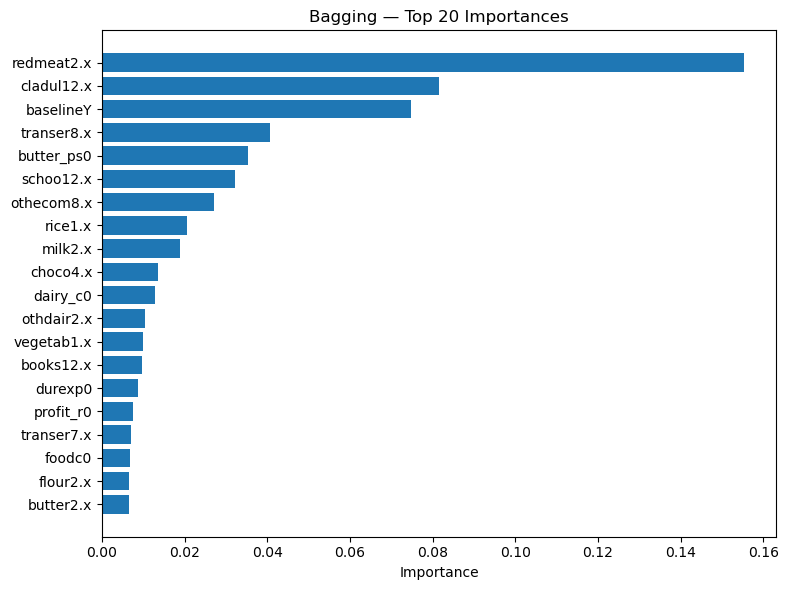

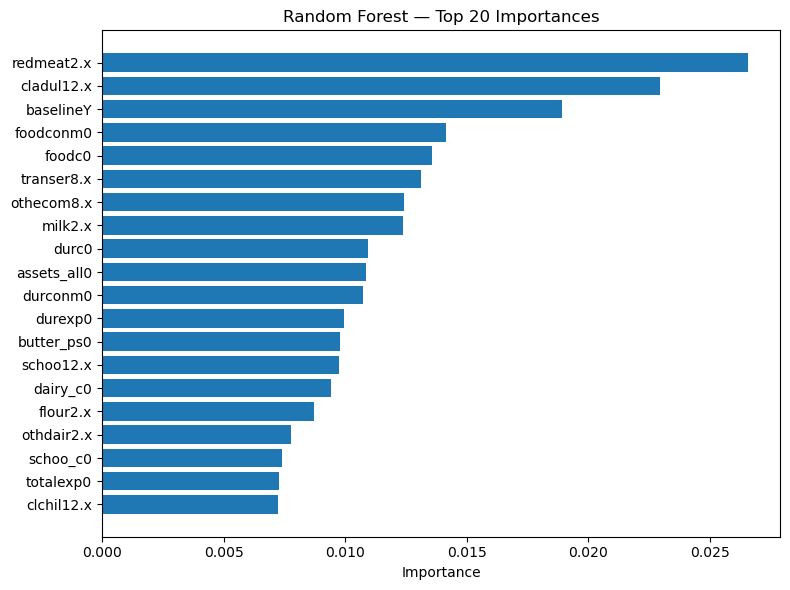

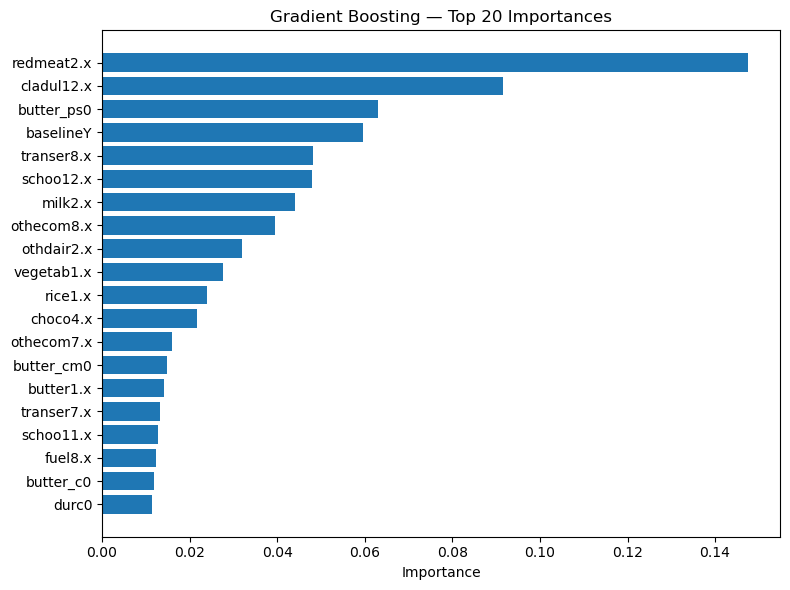

In [12]:
# Importance Matrix
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def plot_top_importance(estimator, feature_names, K=20, title="Feature importance (top-K)"):
    imp = pd.Series(estimator.feature_importances_, index=feature_names)
    top = imp.sort_values(ascending=False).head(K)[::-1]  # reverse for barh order
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.barh(top.index, top.values)
    ax.set_xlabel("Importance")
    ax.set_title(title)
    fig.tight_layout()
    return imp.sort_values(ascending=False)  # also return full, sorted importance

# Bagging Top 20
bag_imp_sorted = plot_top_importance(bag, feature_names, K=20, title="Bagging — Top 20 Importances")

# Random Forest Top 20
rf_imp_sorted = plot_top_importance(rf, feature_names, K=20, title="Random Forest — Top 20 Importances")

# Gradient Boosting Top 20
gbr_imp_sorted = plot_top_importance(gbr_big, feature_names, K=20, title="Gradient Boosting — Top 20 Importances")



[counts] |bag∩rf∩gbr| = 9
[counts] |bag∩rf| = 13, |bag∩gbr| = 13, |rf∩gbr| = 10
[counts] union size (top-20 across all) = 33
               bag      rf     gbr  joint_geom
redmeat2.x  0.1554  0.0265  0.1474      0.0847
cladul12.x  0.0815  0.0229  0.0915      0.0555
baselineY   0.0748  0.0189  0.0597      0.0439
transer8.x  0.0407  0.0131  0.0482      0.0295
butter_ps0  0.0354  0.0098  0.0629      0.0279
schoo12.x   0.0322  0.0098  0.0479      0.0247
othecom8.x  0.0272  0.0124  0.0394      0.0237
milk2.x     0.0188  0.0124  0.0441      0.0217
rice1.x     0.0206  0.0058  0.0239      0.0142
othdair2.x  0.0105  0.0078  0.0319      0.0137
choco4.x    0.0135  0.0061  0.0217      0.0121
vegetab1.x  0.0100  0.0051  0.0276      0.0112
dairy_c0    0.0129  0.0094  0.0053      0.0086
durc0       0.0047  0.0109  0.0113      0.0084
flour2.x    0.0066  0.0087  0.0095      0.0082
butter_cm0  0.0054  0.0055  0.0147      0.0076
transer7.x  0.0070  0.0044  0.0133      0.0074
clchil12.x  0.0052  0.0072  0

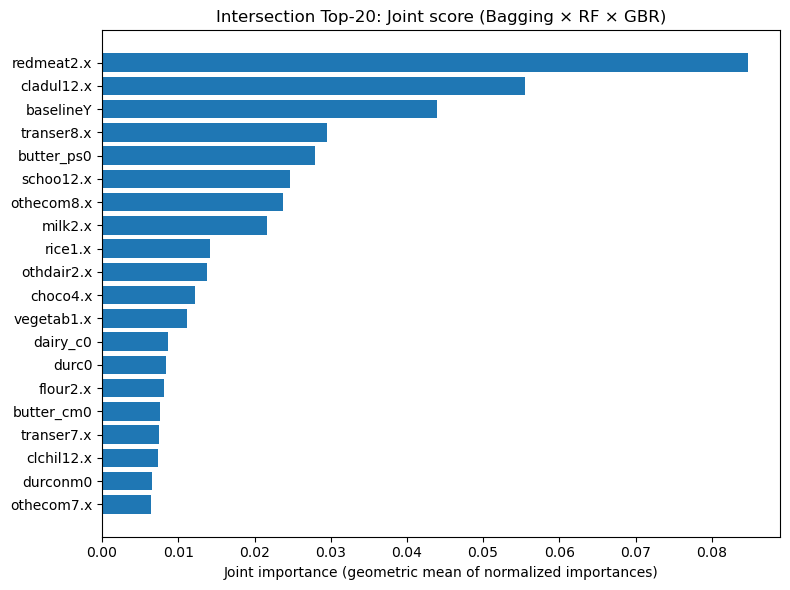

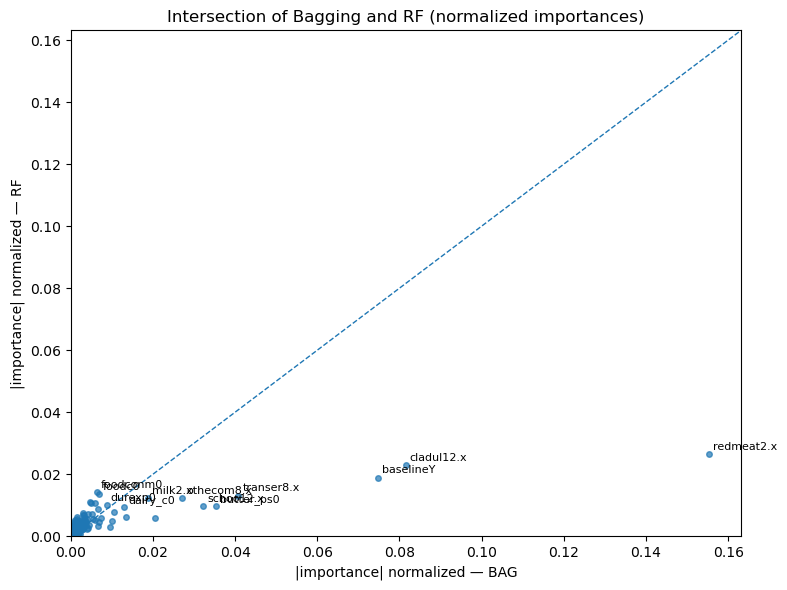

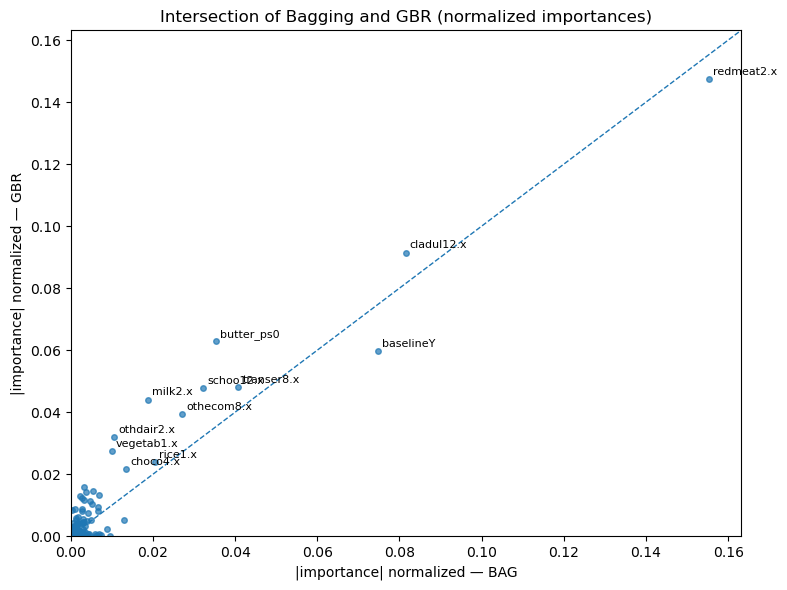

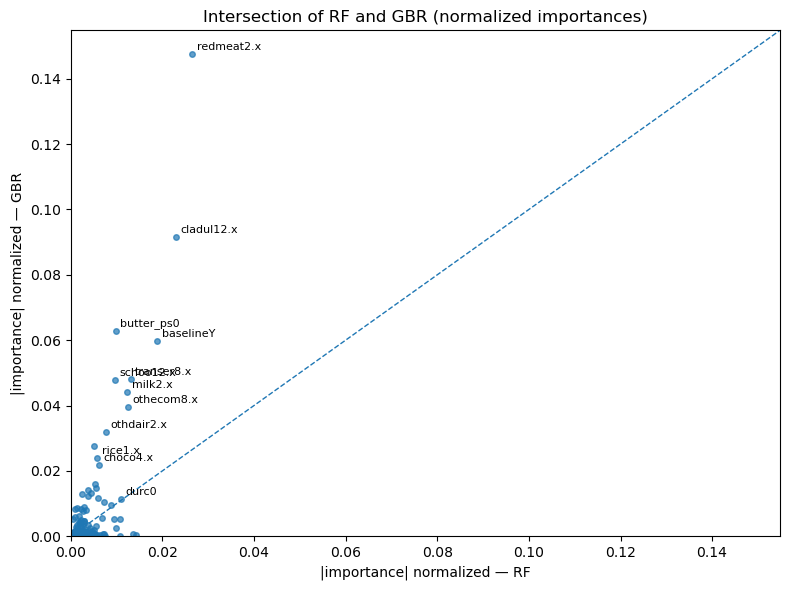

In [13]:
# ===== Tree-Model Intersections: Bagging, RF, Gradient Boosting =====
import numpy as np, pandas as pd
import matplotlib.pyplot as plt

# 1) Build aligned importance table (fill missing with 0)
imp_df = pd.concat(
    [
        bag_imp_sorted.rename("bag"),
        rf_imp_sorted.rename("rf"),
        gbr_imp_sorted.rename("gbr"),
    ],
    axis=1
).fillna(0.0)

# 2) Normalize importances within each model (sum to 1) for comparability
imp_norm = imp_df.div(imp_df.sum(axis=0), axis=1)

# 3) Intersection sets of top-K features
K = 20
top_bag = set(imp_norm["bag"].nlargest(K).index)
top_rf  = set(imp_norm["rf"].nlargest(K).index)
top_gbr = set(imp_norm["gbr"].nlargest(K).index)

intersection_3 = top_bag & top_rf & top_gbr
intersection_bag_rf  = top_bag & top_rf
intersection_bag_gbr = top_bag & top_gbr
intersection_rf_gbr  = top_rf & top_gbr
union_3 = top_bag | top_rf | top_gbr

print(f"[counts] |bag∩rf∩gbr| = {len(intersection_3)}")
print(f"[counts] |bag∩rf| = {len(intersection_bag_rf)}, |bag∩gbr| = {len(intersection_bag_gbr)}, |rf∩gbr| = {len(intersection_rf_gbr)}")
print(f"[counts] union size (top-{K} across all) = {len(union_3)}")

# 4) Joint importance score (geometric mean across models)
#    If a feature has zero in any model, the geo-mean is 0 (sensible for intersections).
joint_all = (imp_norm["bag"] * imp_norm["rf"] * imp_norm["gbr"]) ** (1/3)
joint_all = joint_all.rename("joint_geom")

# 5) Plot: Top-20 by joint score
topJ = joint_all.sort_values(ascending=False).head(20).iloc[::-1]  # reverse for barh order
fig, ax = plt.subplots(figsize=(8, 6))
ax.barh(topJ.index, topJ.values)
ax.set_xlabel("Joint importance (geometric mean of normalized importances)")
ax.set_title(f"Intersection Top-20: Joint score (Bagging × RF × GBR)")
fig.tight_layout()
fig.savefig("trees_jointimportance_bag_rf_gbr_top20.png", dpi=300)

# 6) Pairwise scatter comparisons with 45° line
def pair_scatter(xcol, ycol, title, fname, annotate_n=12):
    x = imp_norm[xcol]
    y = imp_norm[ycol]
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.scatter(x, y, s=16, alpha=0.7)
    lim = (0, max(x.max(), y.max()) * 1.05)
    ax.plot(lim, lim, ls="--", lw=1)
    ax.set_xlim(lim); ax.set_ylim(lim)
    ax.set_xlabel(f"|importance| normalized — {xcol.upper()}")
    ax.set_ylabel(f"|importance| normalized — {ycol.upper()}")
    ax.set_title(title)
    # annotate top points by average rank to avoid clutter
    avg_rank = (x.rank(ascending=False) + y.rank(ascending=False)) / 2
    top_idx = avg_rank.nsmallest(annotate_n).index
    for f in top_idx:
        ax.annotate(f, (x.loc[f], y.loc[f]), xytext=(3, 3), textcoords="offset points", fontsize=8)
    fig.tight_layout()
    fig.savefig(fname, dpi=300)

pair_scatter("bag", "rf",  "Intersection of Bagging and RF (normalized importances)",
             "trees_intersection_bag_rf.png")
pair_scatter("bag", "gbr", "Intersection of Bagging and GBR (normalized importances)",
             "trees_intersection_bag_gbr.png")
pair_scatter("rf",  "gbr", "Intersection of RF and GBR (normalized importances)",
             "trees_intersection_rf_gbr.png")

# 7) Optional: report a small table of top-K intersection with per-model importances and joint
report = pd.concat([imp_norm.loc[topJ.index], joint_all.loc[topJ.index]], axis=1) \
           .sort_values("joint_geom", ascending=False)
print(report.round(4).head(20))
report.to_csv("trees_intersection_report_top20.csv")


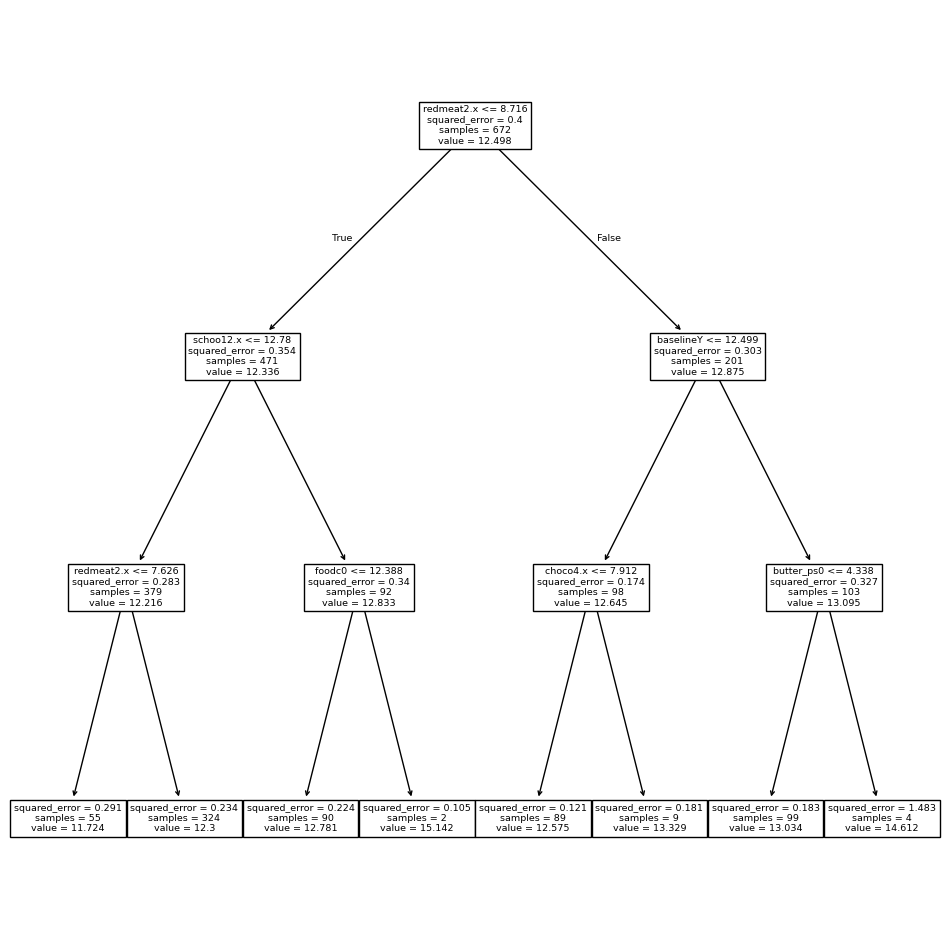

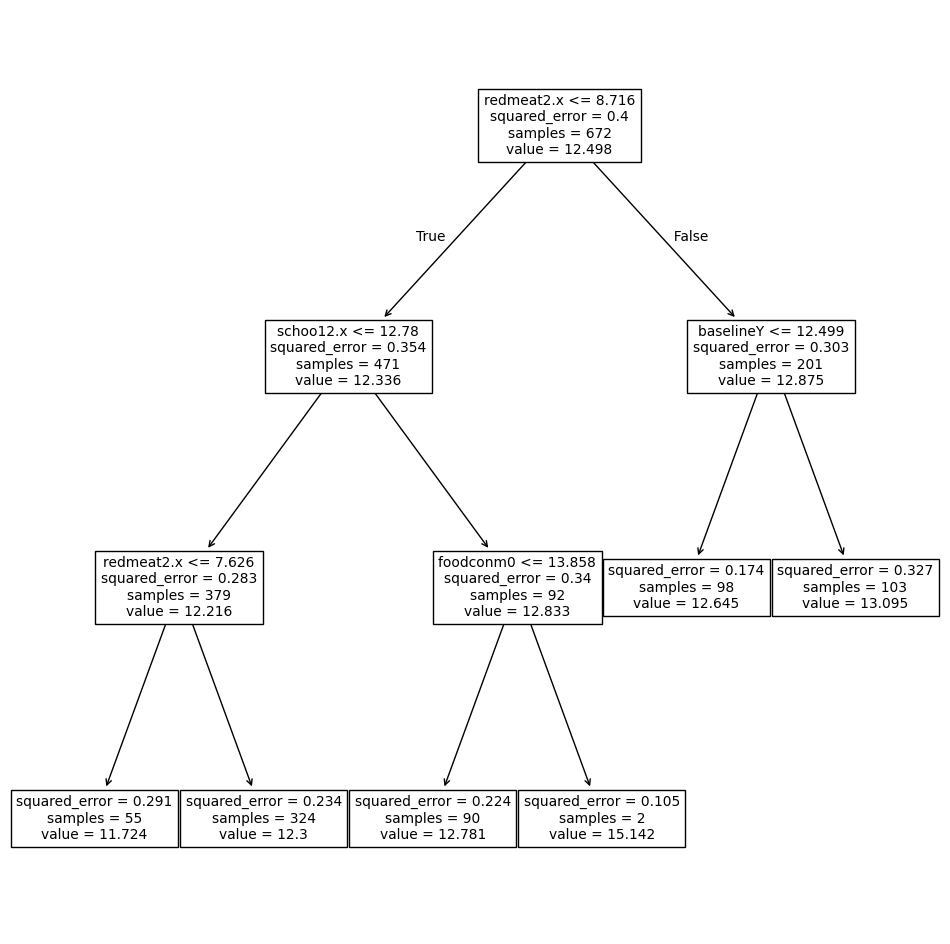

In [14]:
# Single Tree
from sklearn.tree import (DecisionTreeClassifier as DTC,
                          DecisionTreeRegressor as DTR,
                          plot_tree,
                          export_text)
reg = DTR(max_depth=3)
reg.fit(X_train, y_train)
ax = subplots(figsize=(12,12))[1]
plot_tree(reg,
          feature_names=feature_names,
          ax=ax);


ccp_path = reg.cost_complexity_pruning_path(X_train, y_train)
kfold = skm.KFold(5,
                  shuffle=True,
                  random_state=10)
grid = skm.GridSearchCV(reg,
                        {'ccp_alpha': ccp_path.ccp_alphas},
                        refit=True,
                        cv=kfold,
                        scoring='neg_mean_squared_error')
G = grid.fit(X_train, y_train)


best_ = grid.best_estimator_
np.mean((y_test - best_.predict(X_test))**2)


ax = subplots(figsize=(12,12))[1]
plot_tree(G.best_estimator_,
          feature_names=feature_names,
          ax=ax);


In [ ]:
# Partial Dependence
# ==== Partial Dependence / ICE for tree models ====
# Assumes: gbr_big (fitted), X (DataFrame), feature_names (list of column names)
from sklearn.inspection import PartialDependenceDisplay
import matplotlib.pyplot as plt
import numpy as np

# convenience: map names -> column indices
name_to_idx = {n:i for i,n in enumerate(feature_names)}

targets_1d = ["baselineY", "redmeat2.x", "schoo12.x"]
targets_2d = [("redmeat2.x", "baselineY")]  # interaction surface

# 1) 1D PDP + ICE, one plot per feature
for fname in targets_1d:
    fig = plt.figure(figsize=(7,5))
    ax = plt.gca()
    PartialDependenceDisplay.from_estimator(
        gbr_big,
        X,
        features=[name_to_idx[fname]],
        kind="both",              # PDP + ICE
        centered=True,            # zero at average effect
        grid_resolution=50,
        ax=ax
    )
    ax.set_title(f"Partial dependence and ICE — {fname}")
    fig.tight_layout()
    fig.savefig(f"pdp_{fname.replace('.', '_')}.png", dpi=300)

# 2) 2D PDP (interaction)
for f1, f2 in targets_2d:
    fig = plt.figure(figsize=(7,5))
    ax = plt.gca()
    PartialDependenceDisplay.from_estimator(
        gbr_big,
        X,
        features=[(name_to_idx[f1], name_to_idx[f2])],
        kind="average",
        grid_resolution=40,
        ax=ax
    )
    ax.set_title(f"2D partial dependence — {f1} × {f2}")
    fig.tight_layout()
    fig.savefig(f"pdp2d_{f1.replace('.','_')}_{f2.replace('.','_')}.png", dpi=300)
